# Estimating difference between conversion rate in A/B groups

In [1]:
import pandas as pd
import scipy as sp
import daft

import matplotlib.pyplot as plt
import numpy as np

from abtools.bayesian import BinaryABModel
from abtools.frequentist import permutation_test

%matplotlib inline
#plt.xkcd()

## Generate artificial data

Suppose our control group consists of 25k samples and has 10% percent conversion rate. Test (experiment) groups has 2.5% relative larger conversion rate.

In [2]:
p = .1
size = 25000
delta_true = .025

a = sp.stats.bernoulli.rvs(p=p, size=size, random_state=8228)
b = sp.stats.bernoulli.rvs(p=p*(1+delta_true), size=size, random_state=8228)

print('A - Mean: %.4f, std: %.2f' % (a.mean(), a.std()))
print('B - Mean: %.4f, std: %.2f' % (b.mean(), b.std()))
print('B better A on %.4f = %d%%' % (b.mean()- a.mean(), (b.mean()/a.mean()-1)*100))

A - Mean: 0.1010, std: 0.30
B - Mean: 0.1035, std: 0.30
B better A on 0.0025 = 2%


In [3]:
model = BinaryABModel(a, b)
model.fit()

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


         Current function value: 16501.024798
         Iterations: 14
         Function evaluations: 160
         Gradient evaluations: 146


100%|██████████| 10000/10000 [00:05<00:00, 1869.36it/s]


In [4]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$p_A$,0.100959,0.001858,0.000047,0.097282,0.104440
$p_B$,0.103574,0.001894,0.000054,0.100173,0.107353
$A_{\sigma^2}$,0.090763,0.001483,0.000037,0.087819,0.093532
$B_{\sigma^2}$,0.092843,0.001502,0.000043,0.090138,0.095829
$\Delta_p$,0.002614,0.002650,0.000071,-0.002375,0.008044
$\Delta_{\sigma}$,0.003432,0.003477,0.000093,-0.003058,0.010600
Effect size,0.008628,0.008744,0.000233,-0.007710,0.026656


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f740ee7a438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f740d70d208>], dtype=object)

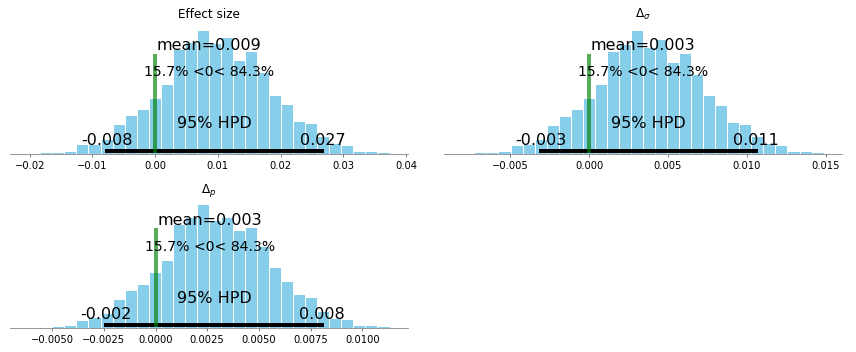

In [5]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f740d660cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f740ee7a828>], dtype=object)

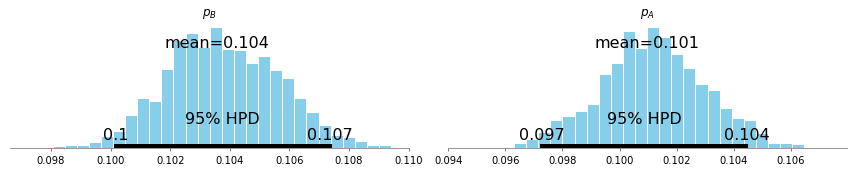

In [6]:
model.plot_params()

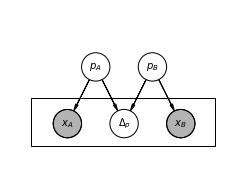

In [7]:
pgm = daft.PGM([4, 3], origin=[0, 0])
pgm.add_node(daft.Node("pA", r"$p_A$", 1.5, 2))
pgm.add_node(daft.Node("pB", r"$p_B$", 2.5, 2))
pgm.add_node(daft.Node("A_conv", r"$x_A$", 1, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("B_conv", r"$x_B$", 3, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("d_conv", r"$\Delta_{p}$", 2, 1, aspect=1))

pgm.add_edge('pA','A_conv')
pgm.add_edge('pB','B_conv')
pgm.add_edge('pA','d_conv')
pgm.add_edge('pB','d_conv')

pgm.add_plate(daft.Plate([0.35, 0.7, 3.25, 0.75], shift=-0.1))
pgm.render()

pgm.figure.savefig("conversion_model.png", dpi=350)
pgm.figure.savefig("conversion_model.pdf", dpi=350, )

100%|██████████| 10000/10000 [00:07<00:00, 1337.13it/s]

Fisher's exact permutation test with 10000 permutations:
----------------------------------------------------------
	Observed difference of means (E(B) - E(A)) = 0.00
	Null distribution's 95% confidence interval = [-0.01, 0.01]
	Two-sided p-value = 0.3422
	Null hypotesis is not rejected


(0.3422, False)

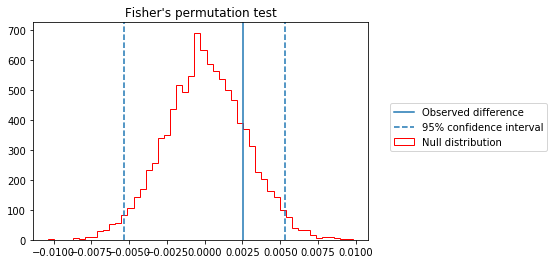

In [7]:
permutation_test(a, b, 10000)

In [8]:
from scipy.stats import norm

def se(std, n):
    return std / np.sqrt(n)

In [9]:
def significance_probability(a, b):
    a_se = se(a.std(), len(a))
    b_se = se(b.std(), len(b))
    return max(2*norm.cdf(abs(a.mean() - b.mean()) / (a_se + b_se)) - 1, 0)


In [10]:
significance_probability(a, b)

0.48923991791342281